# <h1><b><I> General Setup

In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


In [2]:
offsetaxisresolution

0.20000004768371582

In [3]:
lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)
lonmeshrecon, latmeshrecon = np.meshgrid(spatialaxis, spatialaxis)

logjacobtrue = makelogjacob(log10eaxistrue)    

In [4]:
numberoftruevaluesamples = int(3e3)
Nsamples=numberoftruevaluesamples
truelambda          = 0.4
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 2
truelogmassval      = 0.5

In [5]:
psfnorm_lonrecon_mesh, psfnorm_lontrue_mesh = np.meshgrid(spatialaxis,spatialaxistrue)

unnormedpsfvals = psf(np.array([psfnorm_lonrecon_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), np.array([psfnorm_lontrue_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), psfnorm_lonrecon_mesh.flatten()*0).reshape(psfnorm_lonrecon_mesh.shape)

/Users/lpin0002/Desktop/DMPipe/utils3d.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


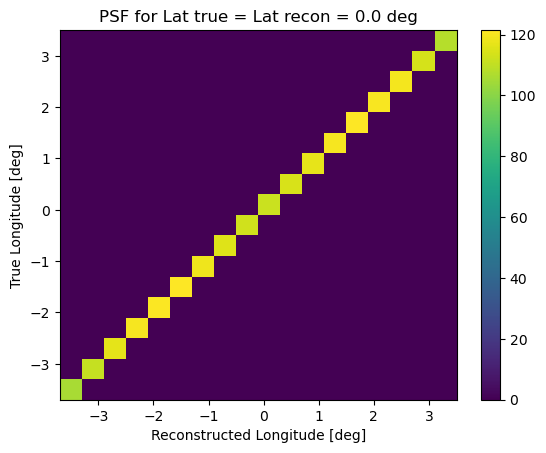

In [6]:
plt.figure()
plt.pcolormesh(spatialaxis, spatialaxistrue, np.exp(unnormedpsfvals))
plt.xlabel("Reconstructed Longitude [deg]")
plt.ylabel("True Longitude [deg]")
plt.title("PSF for Lat true = Lat recon = 0.0 deg")
plt.colorbar()
plt.show()

In [7]:
edispnorm_recon, edispnorm_true = np.meshgrid(log10eaxis,log10eaxistrue)

unnormededispvals = edisp(edispnorm_recon.flatten(),edispnorm_true.flatten(), np.array([edispnorm_recon.flatten()*0+2,edispnorm_recon.flatten()*0+2])).reshape(edispnorm_recon.shape)

/Users/lpin0002/Desktop/DMPipe/utils3d.py:76: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


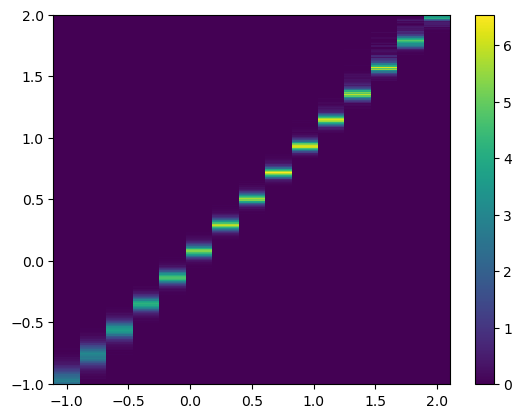

In [8]:
plt.figure()
plt.pcolormesh(log10eaxis, log10eaxistrue, np.exp(unnormededispvals))
plt.colorbar()

# <h1><b>Simulation

## Setup

### Background setup

In [9]:
logbkgpriorvalues = np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue))

logbkgpriorvalues = logbkgpriorvalues - special.logsumexp(logbkgpriorvalues.T+logjacobtrue)

logbkgpriorvalues.shape

(600, 18, 18)

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/91927266.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/91927266.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


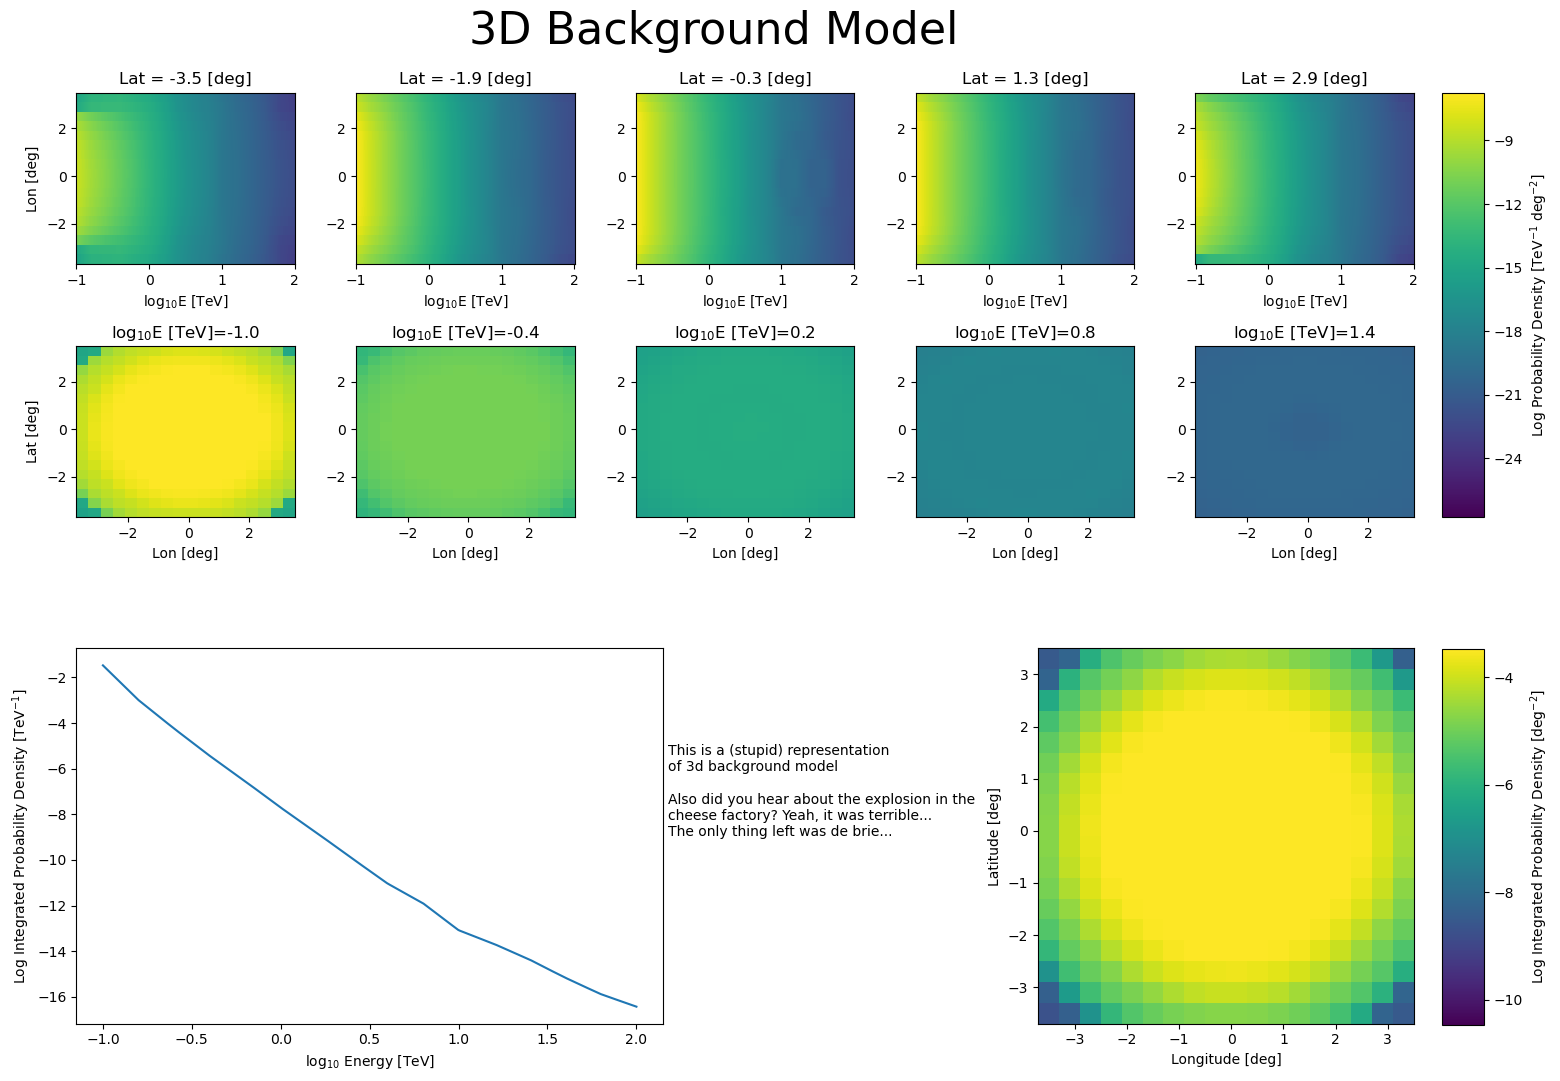

In [10]:
fig,axs = plt.subplots(4,5, figsize=(14,10))


maxval = np.max(logbkgpriorvalues)


spaceconverter = int(np.round(spatialaxistrue.shape[0]/5))
axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,index*spaceconverter].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[index*spaceconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))


plt.suptitle('3D Background Model', y=1.05, size=32)
# fig.tight_layout(pad=5.0)
plt.show()

### Signal Setup

In [11]:
signalspecfunc = darkmatterdoubleinput
signalfunc = setup_full_fake_signal_dist(truelogmassval, signalspecfunc)

In [12]:
log10emeshtrue.shape

(600, 18, 18)

In [13]:
logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

print(logsigpriorvalues.shape)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues.T+logjacobtrue))
logsigpriorvalues.shape

(600, 18, 18)


/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:108: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))


(600, 18, 18)

In [14]:
lonmeshtrue[:,0,0]

array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/502515939.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/502515939.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,14,22)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/502515939.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


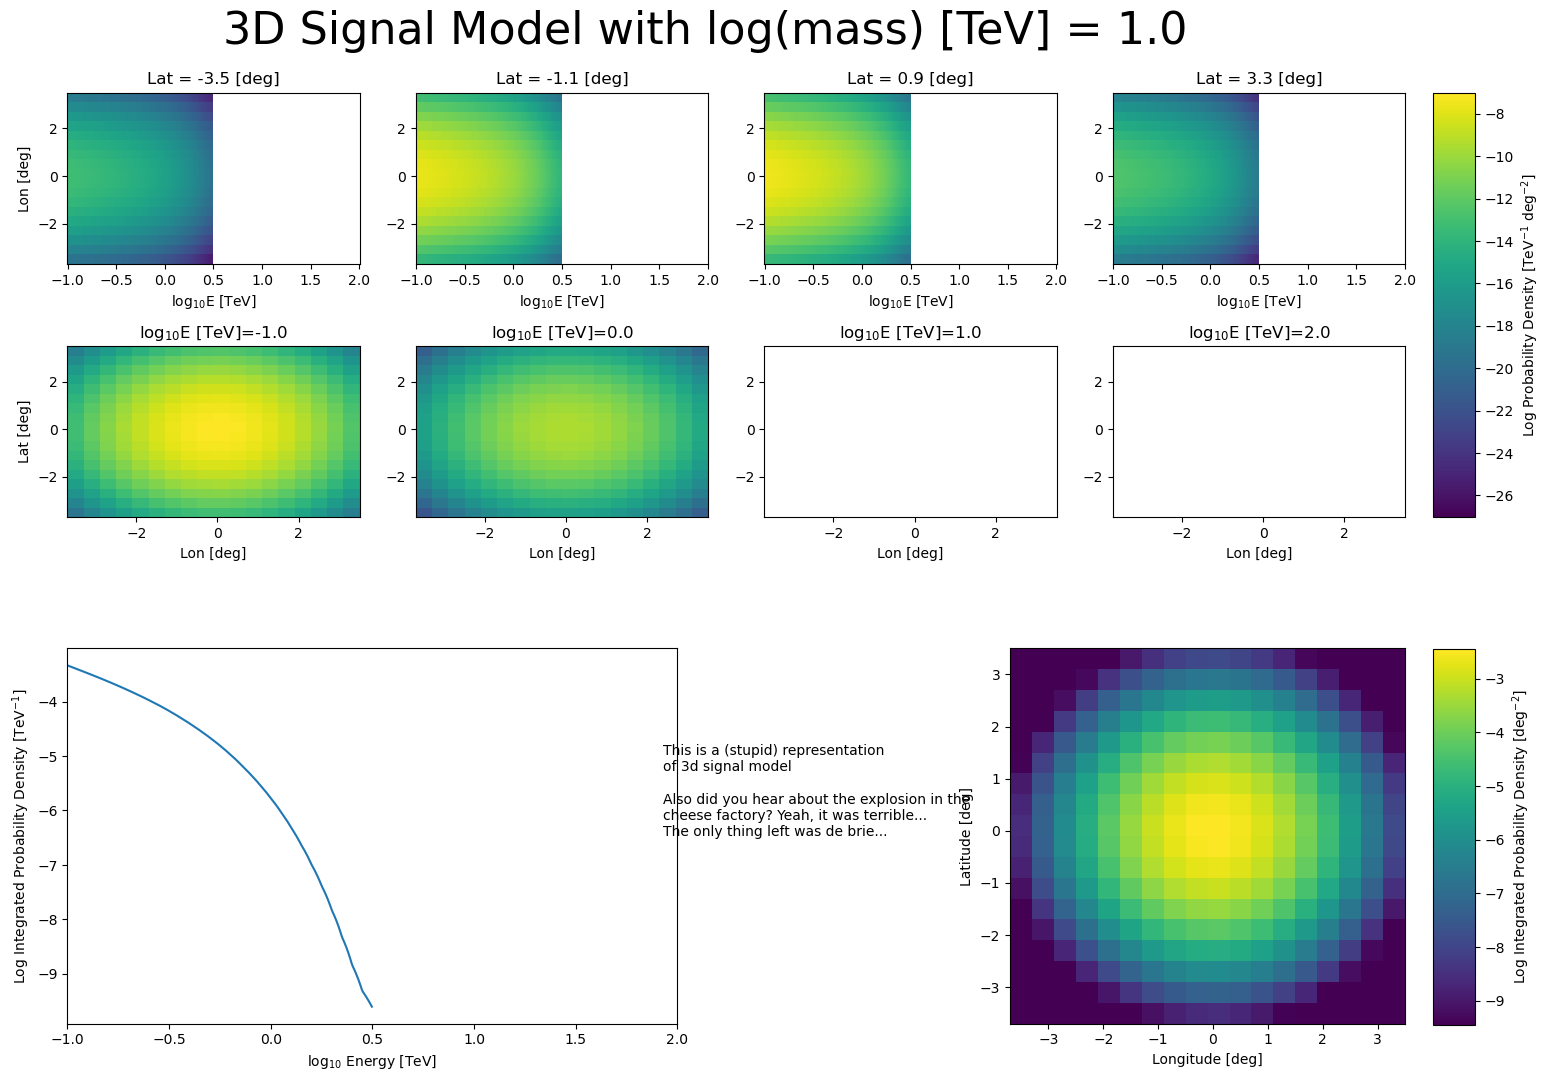

In [15]:
numslices = 4
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

spaceconverter = np.round(np.linspace(0, spatialaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,int(spaceconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[int(spaceconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,14,22)
plt.axis('off')
plt.text(x=-1,y=0.5,s="""This is a (stupid) representation 
of 3d signal model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
plt.suptitle('3D Signal Model with log(mass) [TeV] = 1.0', y=1.05, size=32)

# fig.tight_layout(pad=5.0)
plt.show()

## True Value Simulation

In [16]:
logsigbinnedprior = (logsigpriorvalues.T+logjacobtrue).T
flattened_logsigbinnedprior = logsigbinnedprior.flatten()


logbkgbinnedprior = (logbkgpriorvalues.T+logjacobtrue).T
flattened_logbkgbinnedprior = logbkgbinnedprior.flatten()

In [17]:
sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_logsigbinnedprior, Nsamples=nsig),logsigbinnedprior.shape)
siglogevals = log10eaxistrue[sigresultindices[0]]
siglonvals = spatialaxistrue[sigresultindices[1]]
siglatvals = spatialaxistrue[sigresultindices[2]]

0.5
(600,)


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1114643582.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1114643582.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1114643582.py:38: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


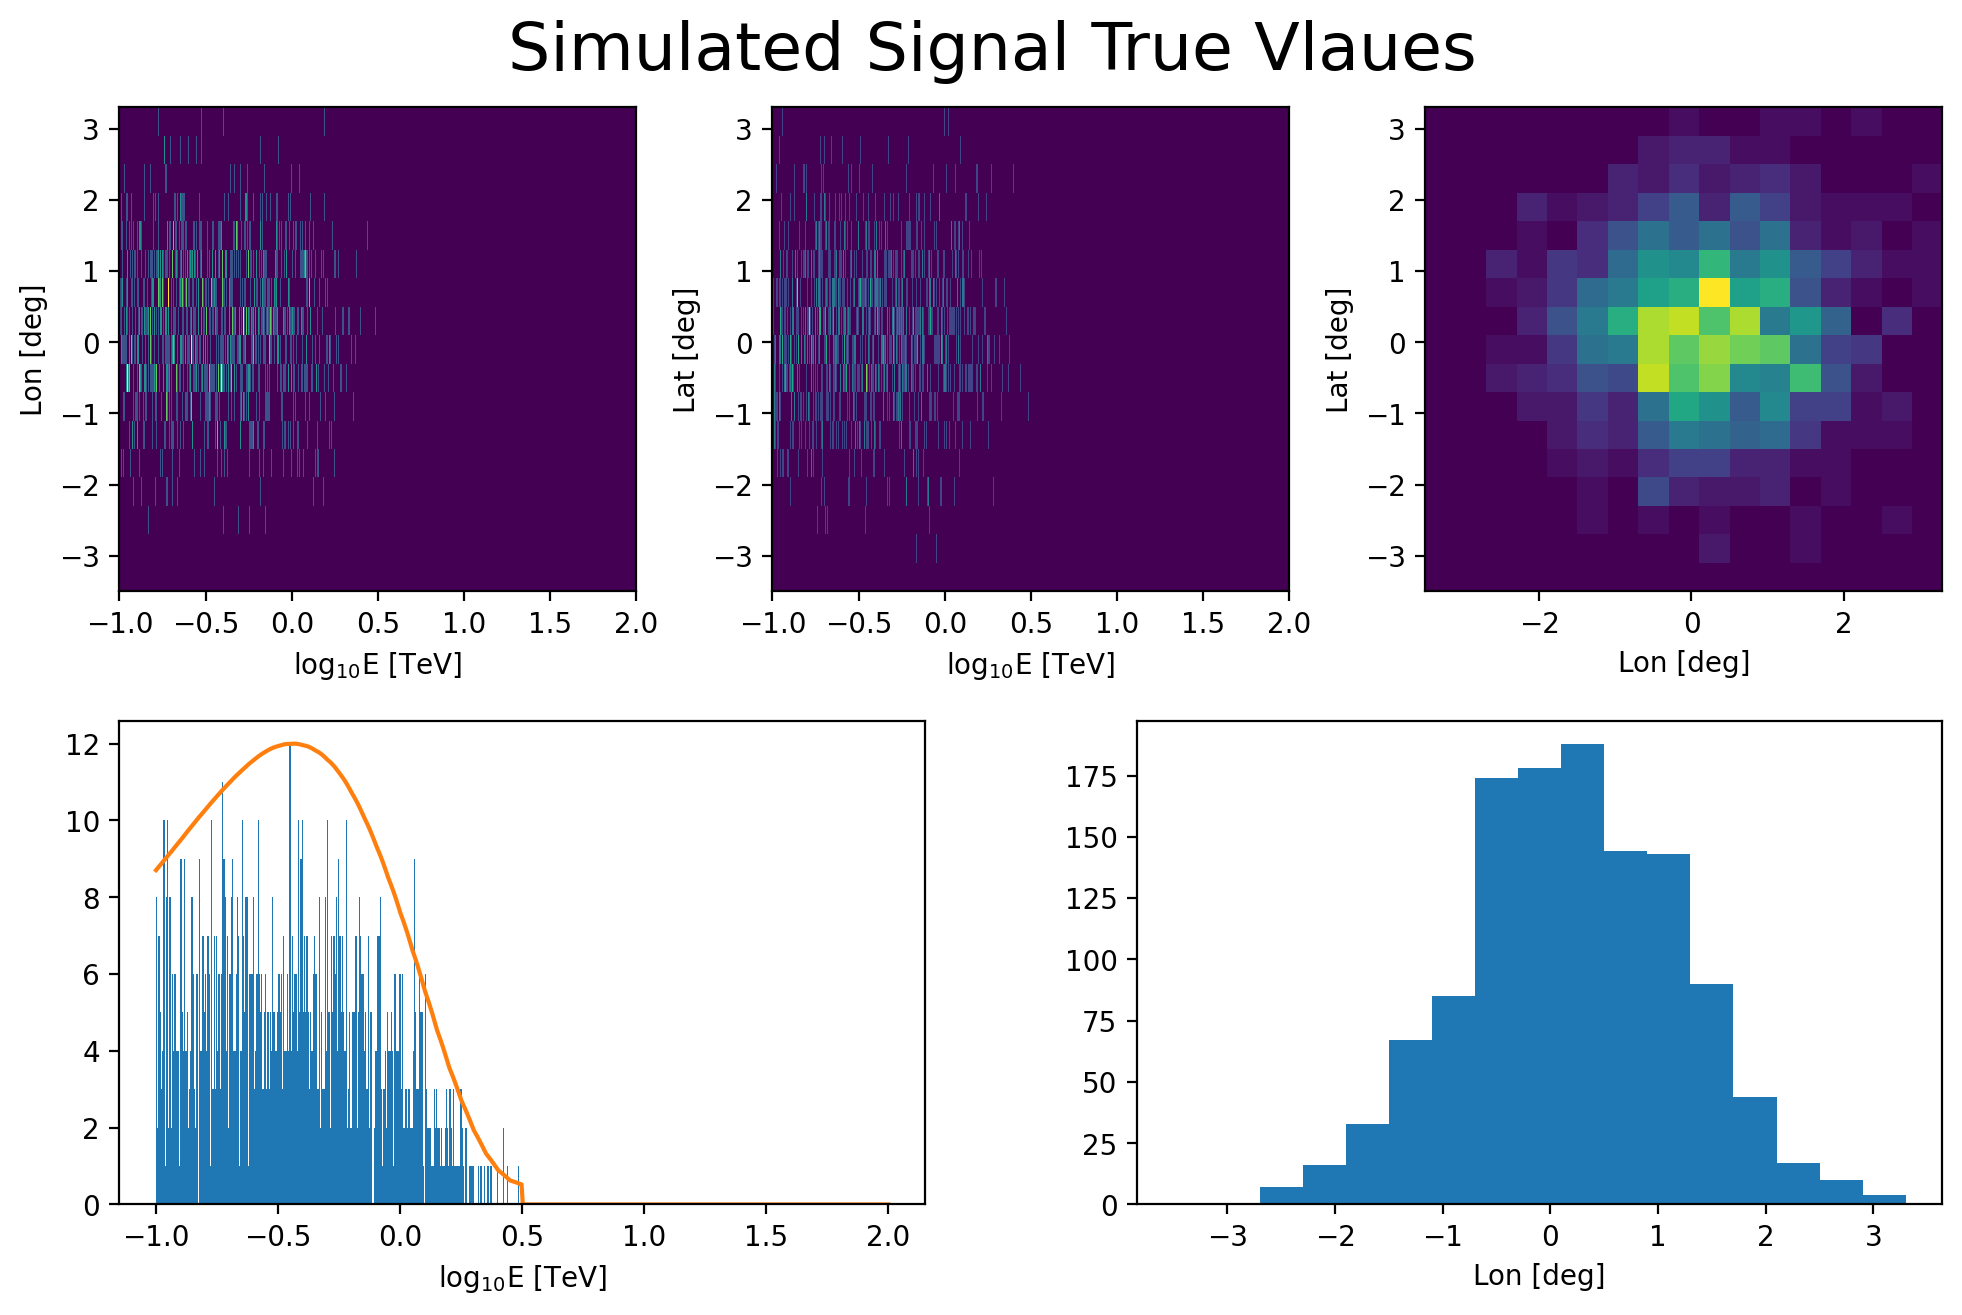

In [18]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(siglogevals, siglonvals, bins=[log10eaxistrue,spatialaxistrue])
plt.ylabel('Lon [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,3,2)
plt.hist2d(siglogevals, siglatvals, bins=[log10eaxistrue,spatialaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lat [deg]')



plt.subplot(2,3,3)
plt.hist2d(siglonvals, siglatvals, bins=[spatialaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

print(truelogmassval)
sigspecvals = np.squeeze(np.exp(logjacobtrue+np.squeeze(darkmatterdoubleinput(truelogmassval, log10eaxistrue))))
print(sigspecvals.shape)
plt.subplot(2,2,3)
sigspechistvals = plt.hist(siglogevals, bins=log10eaxistrue)
plt.plot(log10eaxistrue, sigspecvals/np.max(sigspecvals)*np.max(sigspechistvals[0]))
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(siglonvals, bins=spatialaxistrue)
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

plt.suptitle("Simulated Signal True Vlaues", y=1.05, size=24)
plt.show()

In [19]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_logbkgbinnedprior, Nsamples=nbkg),logbkgbinnedprior.shape)
bkglogevals = log10eaxistrue[bkgresultindices[0]]
bkglonvals = spatialaxistrue[bkgresultindices[1]]
bkglatvals = spatialaxistrue[bkgresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1721193519.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1721193519.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/1721193519.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


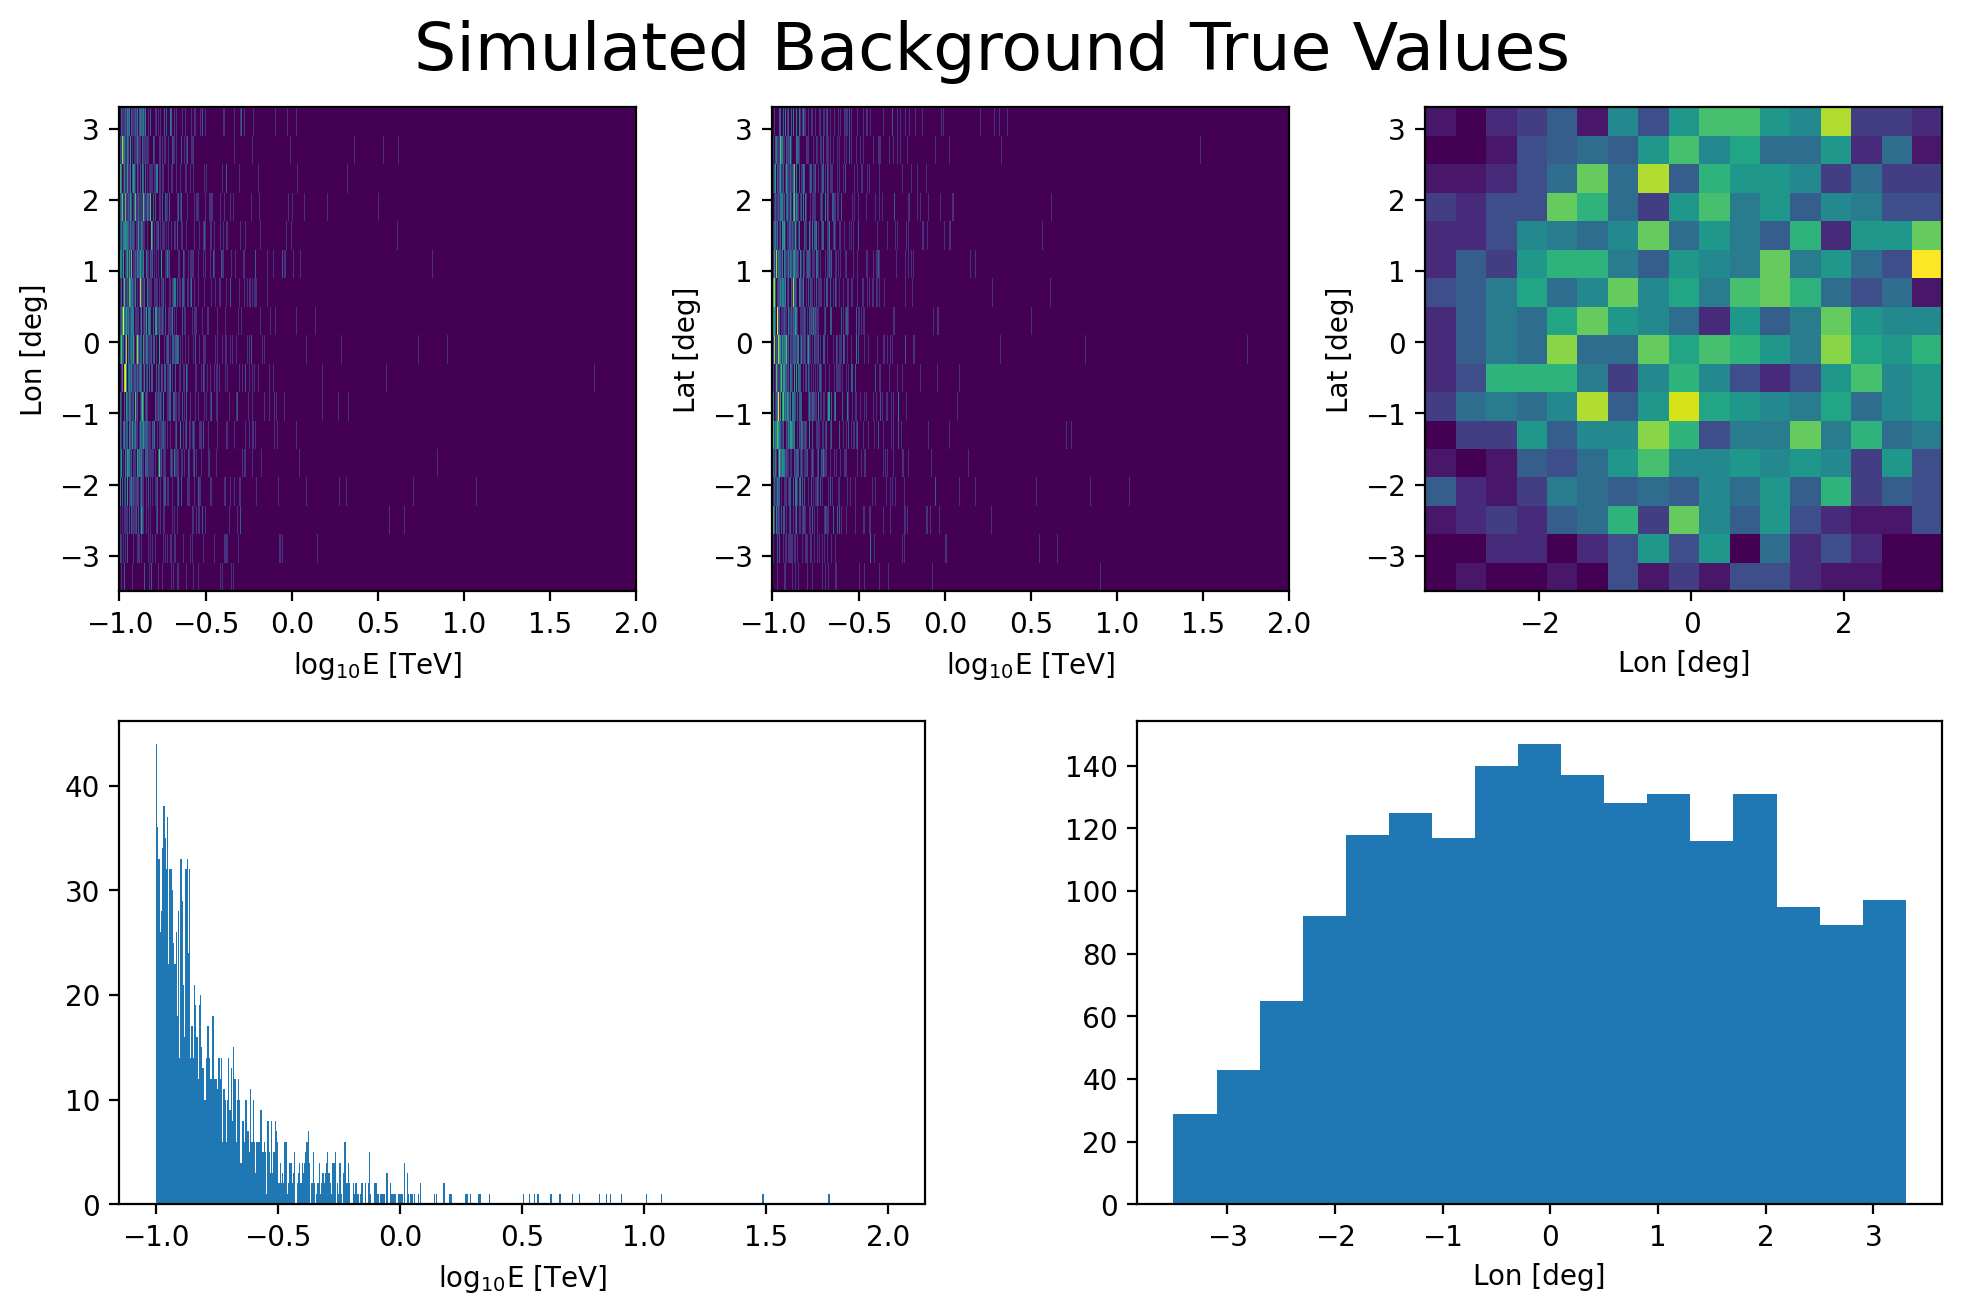

In [20]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkglogevals, bkglonvals, bins=[log10eaxistrue,spatialaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkglogevals, bkglatvals, bins=[log10eaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkglonvals, bkglatvals, bins=[spatialaxistrue,spatialaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(bkglogevals, bins=log10eaxistrue)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkglonvals, bins=spatialaxistrue)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background True Values", y=1.05, size=24)

plt.show()

## Reconstructed Value Simulation

In [21]:
for coord in np.array([siglonvals, siglatvals]).T:
    print(coord)

[-1.5  0.1]
[-0.7 -0.3]
[1.3 0.5]
[-1.9  0.9]
[ 2.1 -1.5]
[1.3 0.5]
[-1.1 -1.5]
[-2.3 -1.1]
[ 0.1 -0.7]
[-0.3  1.3]
[-2.3  0.1]
[-1.1  0.9]
[1.3 0.1]
[-0.3 -0.7]
[ 0.5 -1.1]
[1.7 0.1]
[-1.1 -0.7]
[-1.9  0.9]
[-0.3  0.5]
[0.1 0.5]
[1.3 1.7]
[-1.1  0.5]
[-2.7  0.9]
[0.1 1.7]
[0.1 2.5]
[-0.7 -1.1]
[-0.3 -0.3]
[ 0.5 -1.1]
[-0.7 -2.3]
[ 0.1 -1.5]
[1.7 0.9]
[0.9 0.9]
[ 0.9 -0.3]
[-1.1 -1.9]
[ 0.9 -2.3]
[0.9 2.5]
[-1.1  1.3]
[0.5 0.1]
[-0.7  0.5]
[ 1.3 -1.5]
[1.3 0.5]
[-0.3 -0.7]
[ 0.1 -0.3]
[0.9 1.7]
[0.1 0.1]
[0.5 0.5]
[0.1 0.1]
[ 1.3 -0.7]
[ 1.3 -3.1]
[0.5 0.1]
[-0.7 -0.7]
[0.5 0.9]
[0.1 1.3]
[-1.1 -1.1]
[ 0.1 -1.5]
[ 0.5 -1.5]
[0.9 1.7]
[1.3 0.1]
[0.5 0.9]
[-0.7 -0.3]
[0.5 0.9]
[0.1 1.3]
[ 1.3 -1.5]
[-1.1  0.1]
[-1.5 -0.3]
[-0.3  2.9]
[1.3 1.3]
[ 0.9 -2.3]
[1.3 0.1]
[-0.7  0.5]
[0.9 0.5]
[ 0.9 -0.7]
[0.9 2.1]
[-0.3 -1.1]
[0.9 0.5]
[0.5 0.5]
[ 1.3 -0.3]
[-0.3  0.9]
[ 0.5 -0.7]
[-1.1  0.1]
[0.5 1.7]
[0.9 0.5]
[-1.5  0.5]
[-0.7  1.3]
[ 0.1 -0.3]
[-0.3 -1.5]
[ 0.9 -1.1]
[-1.5 -0.7]
[-0.3 -1.1

### Signal

In [22]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])]

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:01<00:00, 1128.49it/s]


In [23]:
signal_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])
signal_reshaped_indices = np.unravel_index(signal_spatial_indices, shape=lonmeshrecon.shape)
signal_lon_measured = spatialaxis[signal_reshaped_indices[0]]
signal_lat_measured = spatialaxis[signal_reshaped_indices[1]]


100%|██████████| 1200/1200 [00:10<00:00, 112.58it/s]


In [24]:
spatialaxis.shape

(18,)

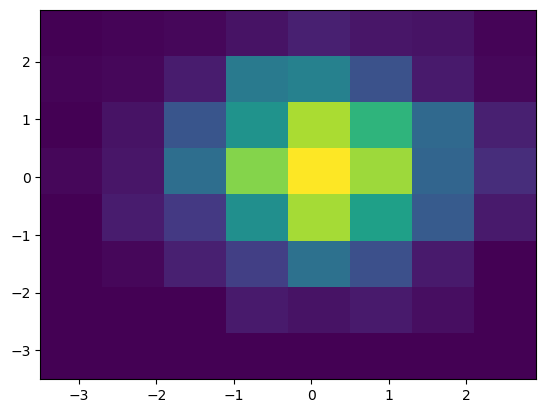

In [25]:
plt.figure()
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=spatialaxis[::2])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2267594078.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2267594078.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2267594078.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


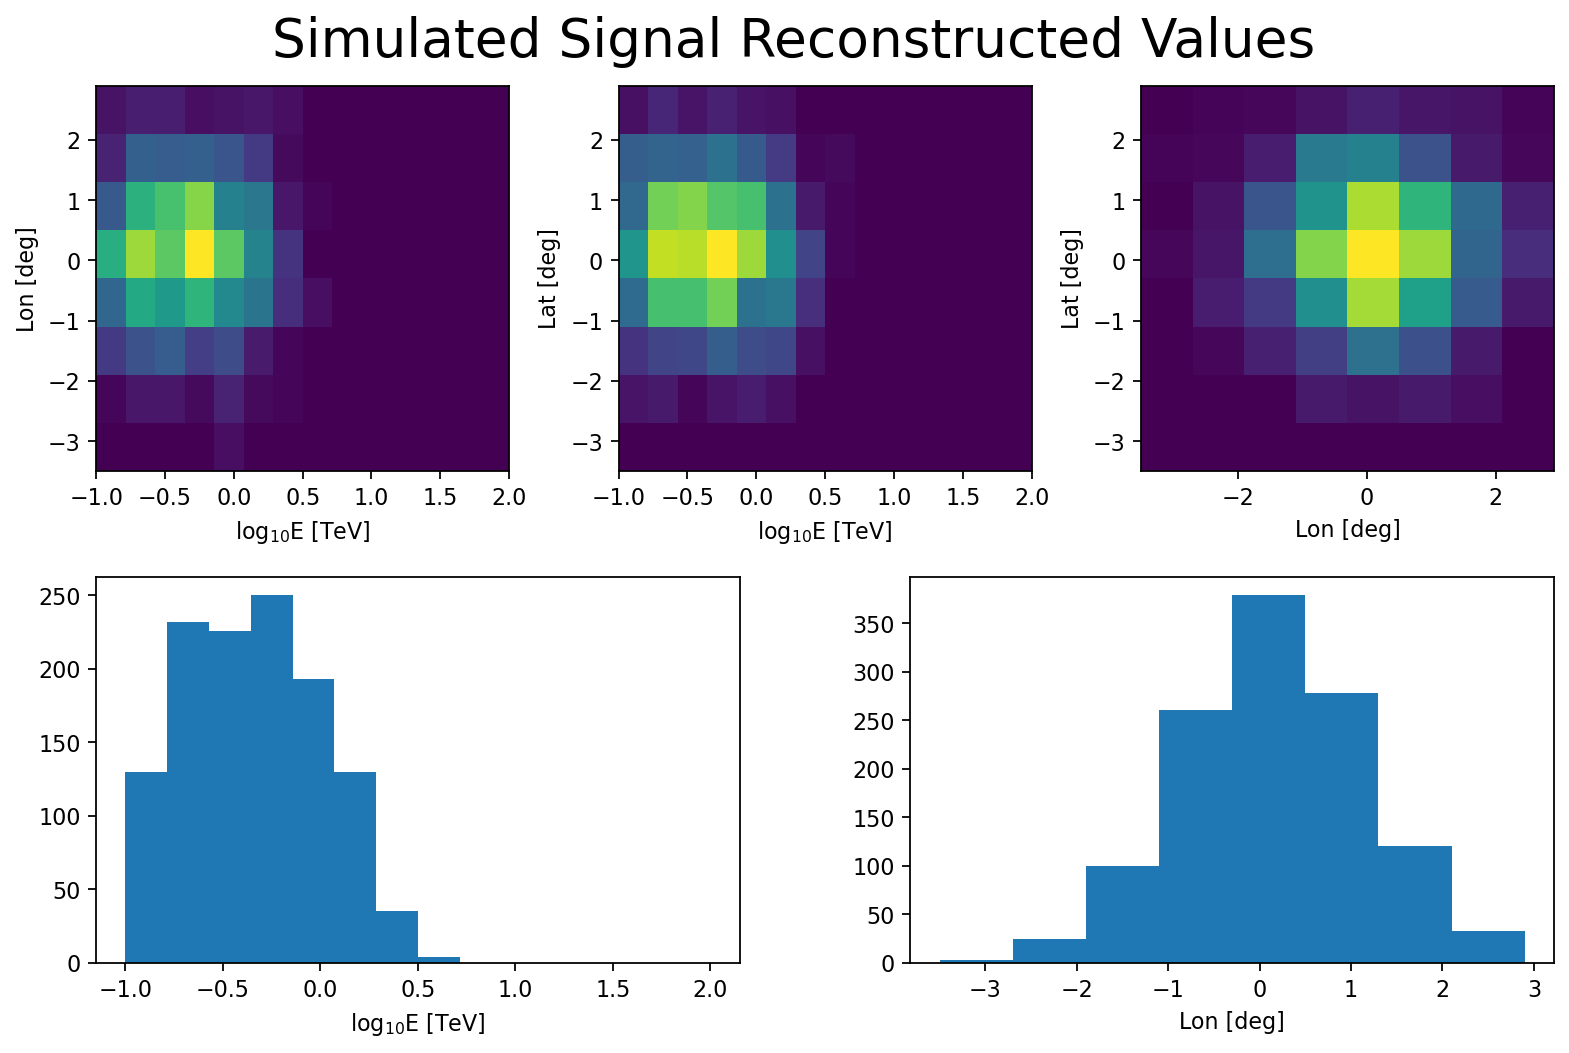

In [26]:
plt.subplots(2,3,dpi=160,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(signal_log10e_measured, signal_lon_measured, bins=[log10eaxis,spatialaxis[::2]])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(signal_log10e_measured, signal_lat_measured, bins=[log10eaxis,spatialaxis[::2]])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=spatialaxis[::2])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(signal_log10e_measured, bins=log10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(signal_lon_measured, bins=spatialaxis[::2])
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Signal Reconstructed Values", y=1.05, size=24)

plt.show()

### Background

In [27]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])]

 24%|██▍       | 432/1800 [00:00<00:01, 1039.42it/s]/Users/lpin0002/Desktop/DMPipe/utils3d.py:172: RuntimeWarning: invalid value encountered in subtract
  logpmf = logpmf - special.logsumexp(logpmf)
100%|██████████| 1800/1800 [00:01<00:00, 1204.33it/s]


In [28]:
bkg_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])
bkg_reshaped_indices = np.unravel_index(bkg_spatial_indices, shape=lonmeshrecon.shape)
bkg_lon_measured = spatialaxis[bkg_reshaped_indices[0]]
bkg_lat_measured = spatialaxis[bkg_reshaped_indices[1]]


100%|██████████| 1800/1800 [00:14<00:00, 125.38it/s]


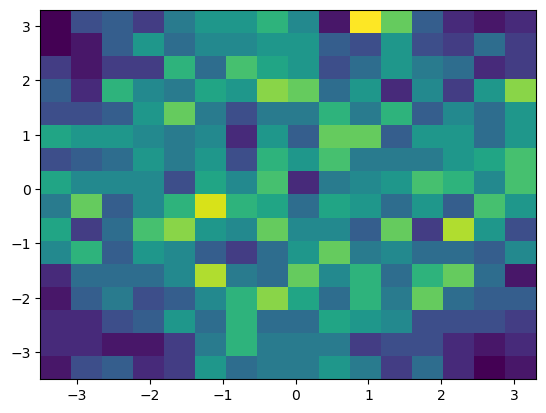

In [29]:
plt.figure()
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[spatialaxis.shape[0]-2, spatialaxis.shape[0]-2])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2782568003.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2782568003.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_32077/2782568003.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


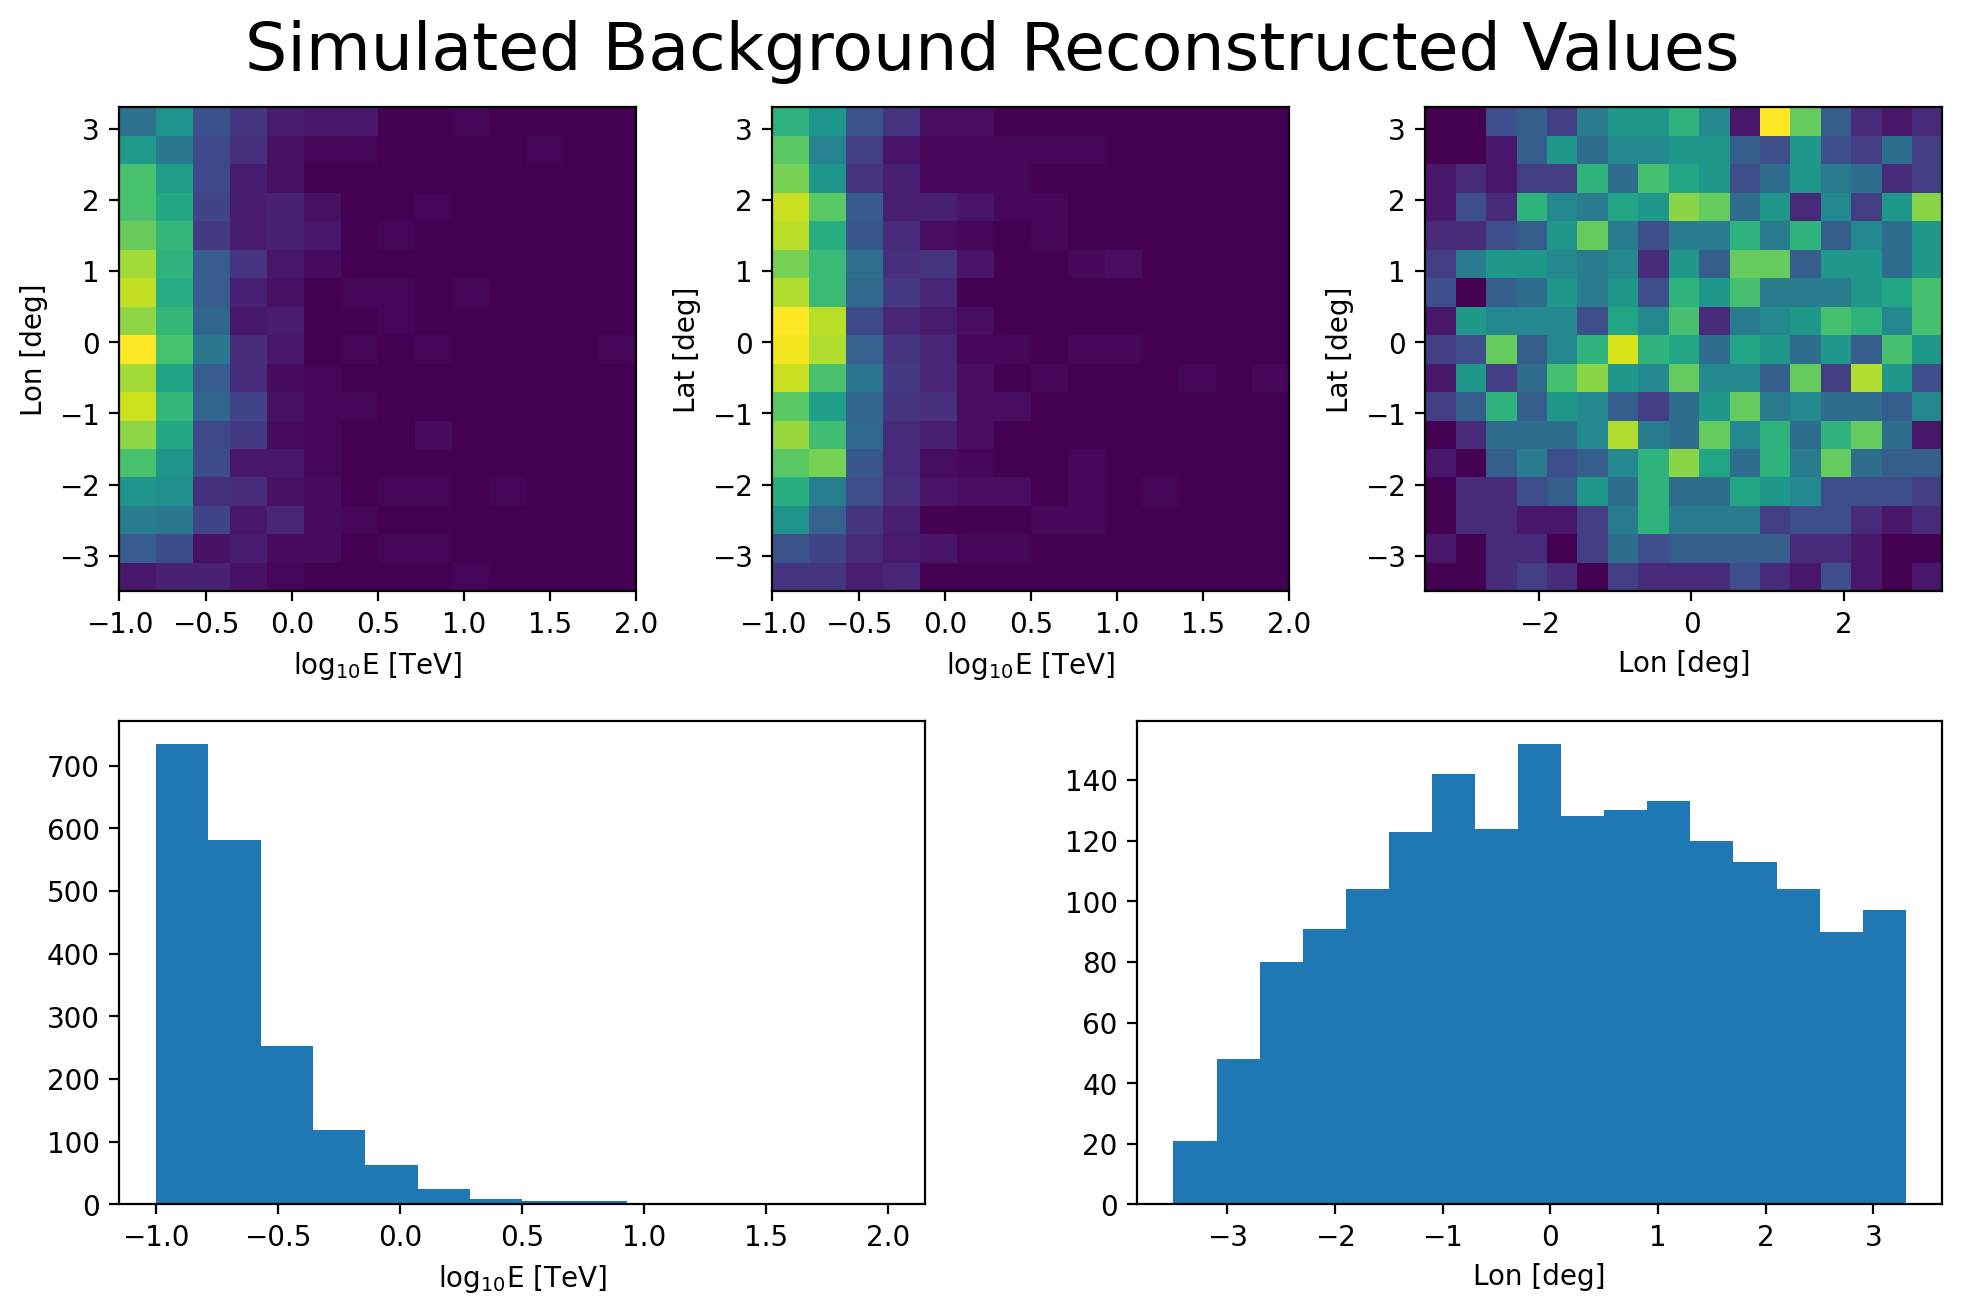

In [30]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkg_log10e_measured, bkg_lon_measured, bins=[log10eaxis,spatialaxis])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkg_log10e_measured, bkg_lat_measured, bins=[log10eaxis,spatialaxis])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[spatialaxis,spatialaxis])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(bkg_log10e_measured, bins=log10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkg_lon_measured, bins=spatialaxis)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background Reconstructed Values", y=1.05, size=24)

plt.show()

## Final simulation output

In [31]:
measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)

# <h1><b>Analysis

## IRF Normalisation

In [32]:
# Save the matrix of psf values in its entirety (not just normalisation values)?
lontrue_mesh_psf, logetrue_mesh_psf, lattrue_mesh_psf, lonrecon_mesh_psf, latrecon_mesh_psf = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue, spatialaxis, spatialaxis)
# psfmatrix = psf(np.array([lonrecon_mesh_psf.flatten(), latrecon_mesh_psf.flatten()]), np.array([lontrue_mesh_psf.flatten(), lattrue_mesh_psf.flatten()]), logetrue_mesh_psf.flatten()).reshape(logetrue_mesh_psf.shape)
psfmatrix = np.load("psfmatrix.npy")
psfnormalisation  = special.logsumexp(psfmatrix, axis=(-2,-1))


    
lontrue_mesh_edisp, logetrue_mesh_edisp, lattrue_mesh_edisp, logerecon_mesh_edisp,  = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue, log10eaxis)


# edispmatrix = edisp(logerecon_mesh_edisp.flatten(), logetrue_mesh_edisp.flatten(), np.array([lontrue_mesh_edisp.flatten(), lattrue_mesh_edisp.flatten()])).reshape(logetrue_mesh_edisp.shape)
edispmatrix = np.load("edispmatrix.npy")
edispnormalisation  = special.logsumexp(edispmatrix+logjacob, axis=-1)




edispnormalisation[edispnormalisation==-np.inf] = 0
psfnormalisation[psfnormalisation==-np.inf] = 0   

edispmatrix = edispmatrix-edispnormalisation[:,:,:,np.newaxis]
psfmatrix = psfmatrix-psfnormalisation[:,:,:,np.newaxis, np.newaxis]

np.save("psfmatrix.npy", psfmatrix)
np.save("edispmatrix.npy", edispmatrix)



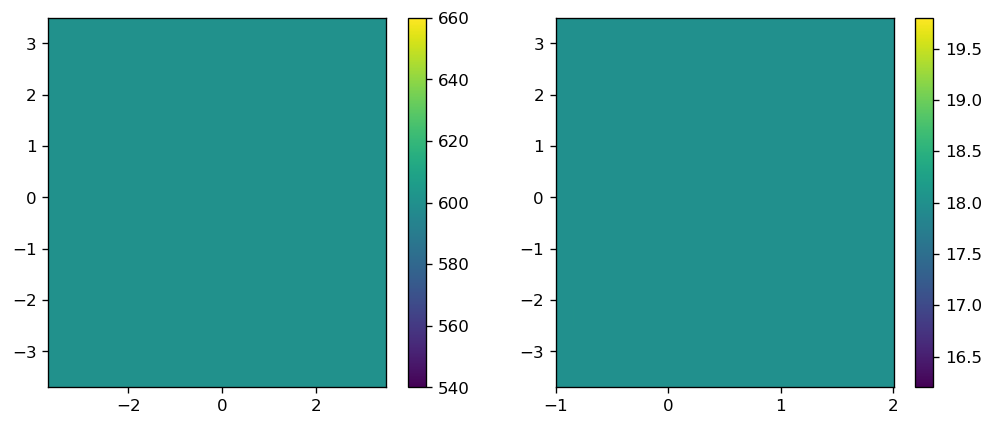

In [33]:
plt.subplots(1,2, figsize=(10,4), dpi=120)
plt.subplot(1,2,1)
plt.pcolormesh(spatialaxistrue, spatialaxistrue, np.exp(special.logsumexp(psfnormalisation, axis=0)))
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(log10eaxistrue, spatialaxistrue, np.exp(special.logsumexp(psfnormalisation, axis=2)).T)
plt.colorbar()


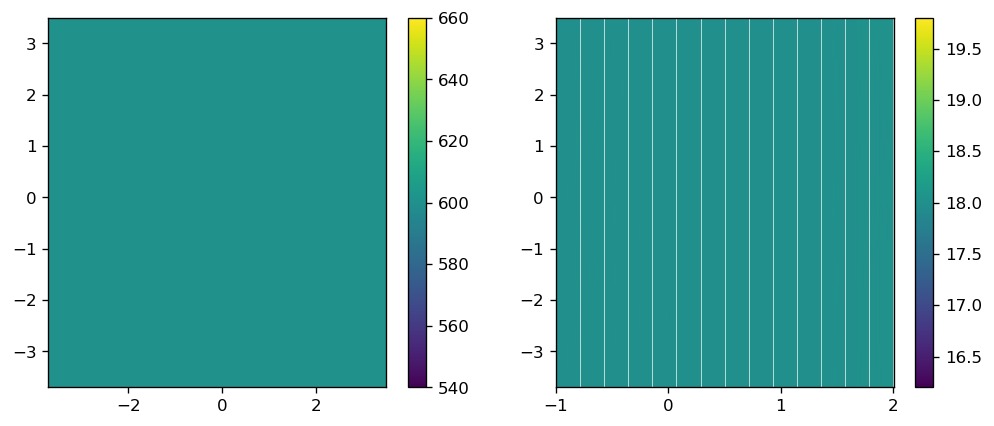

In [34]:
plt.subplots(1,2, figsize=(10,4), dpi=120)
plt.subplot(1,2,1)
plt.pcolormesh(spatialaxistrue, spatialaxistrue, np.exp(special.logsumexp(edispnormalisation, axis=0)))
plt.colorbar()


plt.subplot(1,2,2)
plt.pcolormesh(log10eaxistrue, spatialaxistrue, np.exp(special.logsumexp(edispnormalisation, axis=2)).T)

for val in log10eaxis:
    plt.axvline(val, alpha=1, color='white', lw=0.4)
plt.colorbar()


In [35]:
edispmatrix = edispmatrix-edispnormalisation[:,:,:,np.newaxis]
psfmatrix = psfmatrix-psfnormalisation[:,:,:,np.newaxis, np.newaxis]

## IRF Indices

In [36]:
# lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

# irfproblist = []

# for logeval, coord in notebook_tqdm(zip(measured_log10e, np.array([measured_lon, measured_lat]).T), total=len(list(measured_log10e))):
#     irfproblist.append(psf(coord, np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()]), logetrue_mesh_nuisance.flatten()).reshape(logetrue_mesh_nuisance.shape)+\
#         edisp(logeval, logetrue_mesh_nuisance.flatten(), np.array([lontrue_mesh_nuisance.flatten(), lattrue_mesh_nuisance.flatten()])).reshape(logetrue_mesh_nuisance.shape) - edispnormalisation - psfnormalisation)

In [37]:
# lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

# irfproblist = []

# calcdemderirfvals_temp = functools.partial(calcdemderirfvals, lontrue_mesh_nuisance=lontrue_mesh_nuisance, logetrue_mesh_nuisance=logetrue_mesh_nuisance, lattrue_mesh_nuisance=lattrue_mesh_nuisance, 
#                                            edispnormalisation=edispnormalisation,  psfnormalisation=psfnormalisation)
    
# with Pool(numcores) as pool: 
        
#     for result in notebook_tqdm(pool.imap(calcdemderirfvals_temp, zip(measured_log10e, np.array([measured_lon, measured_lat]).T)), total=len(list(measured_log10e)), ncols=100, desc="Calculating irf values..."):
#             irfproblist.append(result)

#     pool.close() 

In [38]:
lontrue_mesh_nuisance, logetrue_mesh_nuisance, lattrue_mesh_nuisance = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)

irfindexlist = []

    
with Pool(numcores) as pool: 
        
    for result in notebook_tqdm(pool.imap(calcrirfindices, zip(measured_log10e, np.array([measured_lon, measured_lat]).T)), total=len(list(measured_log10e)), ncols=100, desc="Calculating irf values..."):
            irfindexlist.append(result)

    pool.close() 
    
irfindexlist = np.array(irfindexlist)

Calculating irf values...:   0%|                                           | 0/3000 [00:00<?, ?it/s]

Calculating irf values...: 100%|███████████████████████████████| 3000/3000 [00:07<00:00, 424.11it/s]


In [39]:
irfindexlist

array([[ 0,  9,  5],
       [ 1,  8,  7],
       [ 5, 10, 12],
       ...,
       [ 0,  0,  7],
       [ 1,  8, 12],
       [ 0,  3, 15]])

In [40]:
irfindexlist[:,0]

array([0, 1, 5, ..., 0, 1, 0])

In [41]:
assert len(irfindexlist) == Nsamples
assert irfindexlist.ndim==2
assert irfindexlist.shape==(Nsamples, 3)

In [42]:
print(edispnormalisation.shape,edispmatrix[:,:,:,1].shape)
print(psfnormalisation.shape,psfmatrix[:,:,:,1,2].shape)

(600, 18, 18) (600, 18, 18)
(600, 18, 18) (600, 18, 18)


In [43]:
vals = [print(irfcoord,'\n') for irfcoord in irfindexlist]

[0 9 5] 

[1 8 7] 

[ 5 10 12] 

[ 3 11  4] 

[ 0  5 14] 

[ 1 10 12] 

[0 5 6] 

[1 6 3] 

[2 7 9] 

[ 0 12  8] 

[0 9 3] 

[ 4 11  6] 

[ 3  9 12] 

[1 7 8] 

[ 4  6 10] 

[ 3  9 13] 

[2 7 6] 

[ 0 11  4] 

[ 6 10  8] 

[ 2 10  9] 

[ 2 13 12] 

[ 1 10  6] 

[ 1 11  2] 

[ 4 13  9] 

[ 2 15  9] 

[3 6 7] 

[1 8 8] 

[ 1  6 10] 

[3 3 7] 

[1 5 9] 

[ 1 11 13] 

[ 2 11 11] 

[ 5  8 11] 

[0 4 6] 

[ 4  3 11] 

[ 2 15 11] 

[ 4 12  6] 

[ 3  9 10] 

[ 3 10  7] 

[ 1  5 12] 

[ 2 10 12] 

[5 7 8] 

[3 8 9] 

[ 4 13 11] 

[3 9 9] 

[ 2 10 10] 

[1 9 9] 

[ 0  7 12] 

[ 4  1 12] 

[ 3  9 10] 

[2 7 7] 

[ 3 11 10] 

[ 4 12  9] 

[4 6 6] 

[3 5 9] 

[ 2  5 10] 

[ 4 13 11] 

[ 2  9 12] 

[ 5 11 10] 

[0 8 7] 

[ 2 11 10] 

[ 2 12  9] 

[ 2  5 12] 

[4 9 6] 

[2 8 5] 

[ 0 16  8] 

[ 3 12 12] 

[ 5  3 11] 

[ 5  9 12] 

[ 3 10  7] 

[ 2 10 11] 

[ 5  7 11] 

[ 6 14 11] 

[1 6 8] 

[ 0 10 11] 

[ 2 10 10] 

[ 4  8 12] 

[ 5 11  8] 

[ 5  7 10] 

[5 9 6] 

[ 2 13 10] 

[ 3 10 11] 

[ 3 10  5

## Background Marginalisation

In [44]:
bkgpriorarray  = bkgdist(logetrue_mesh_nuisance, lontrue_mesh_nuisance, lattrue_mesh_nuisance)
bkgpriorarray = bkgpriorarray.T - special.logsumexp(bkgpriorarray.T+logjacobtrue)
# print(special.logsumexp(bkgpriorarray.T+logjacobtrue).shape)

bkgmargvals = special.logsumexp(logjacobtrue+bkgpriorarray+edispmatrix[:,:,:,irfindexlist[:,0]].T+psfmatrix[:,:,:,irfindexlist[:,1],irfindexlist[:,2]].T, axis=(1,2,3))
bkgmargvals = np.array(bkgmargvals)
print(bkgmargvals.shape)

(3000,)


## Signal marginalisation

In [45]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')





nbinslogmass            = 81
logmasswindowwidth      = 5/np.sqrt(nsig)


logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth



if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 







nbinslambda            = 101
lambdawindowwidth      = 5/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 


In [46]:

tempsigmargfunction = functools.partial(evaluateformass,lambdarange=lambdarange, bkgmargvals=bkgmargvals, irfindexlist=irfindexlist, specfunc=darkmatterdoubleinput, edispmatrix=edispmatrix, psfmatrix=psfmatrix, 
                                        lontrue_mesh_nuisance=lontrue_mesh_nuisance, logetrue_mesh_nuisance=logetrue_mesh_nuisance, lattrue_mesh_nuisance=lattrue_mesh_nuisance)


# signal_log_marginalisationvalues = []


with Pool(numcores) as pool: 
        
    posterior = pool.map(tempsigmargfunction, tqdm(logmassrange))

    pool.close() 


 25%|██▍       | 20/81 [00:06<00:22,  2.74it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:108: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))
/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
 31%|███       | 25/81 [00:10<00:26,  2.11it/s]/Users/lpin0002/Desktop/DMPipe/BFCalc/createsp

KeyboardInterrupt: 

In [ ]:
# signal_log_marginalisationvalues = np.array(signal_log_marginalisationvalues)
# print(signal_log_marginalisationvalues.shape)

## Calculating posterior

In [ ]:


# log_posterior = []

# for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
#     log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+signal_log_marginalisationvalues[logmassindex,:], np.log(1-lambdaval)+bkgmargvals)) for logmassindex in range(len(list(logmassrange)))])

# log_posterior = np.array(log_posterior)-special.logsumexp(log_posterior)


# log_posterior.shape

In [ ]:
log_posterior = np.array(posterior).T
log_posterior = log_posterior - special.logsumexp(log_posterior)

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_29383/2981469074.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_29383/2981469074.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  extracolormap = cm.get_cmap('Blues_r')


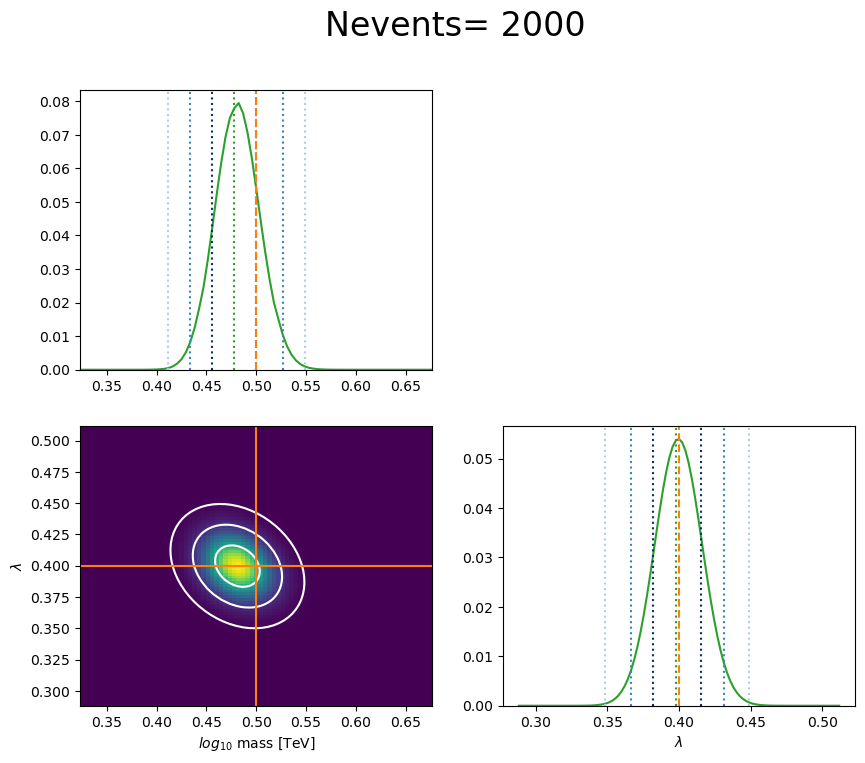

In [ ]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmassval, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior))
ax[1,0].axvline(truelogmassval, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\lambda$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

extracolormap = cm.get_cmap('Blues_r')
confidence_ellipse(logmassrange, lambdarange, np.exp(log_posterior), ax[1,0], n_std=3.0, linewidth=1.5)
confidence_ellipse(logmassrange, lambdarange, np.exp(log_posterior), ax[1,0], n_std=2.0, linewidth=1.5)
confidence_ellipse(logmassrange, lambdarange, np.exp(log_posterior), ax[1,0], n_std=1.0, linewidth=1.5)


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlabda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentiles.append(lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()])


ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlabda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\lambda$')
ax[1,1].set_ylim([0, None])


plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmassval}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

In [ ]:
a1 = np.array([0,1,-1])
a2 = np.array([1,2,3,4])


a1[:, np.newaxis]+a2[np.newaxis,:]

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [0, 1, 2, 3]])

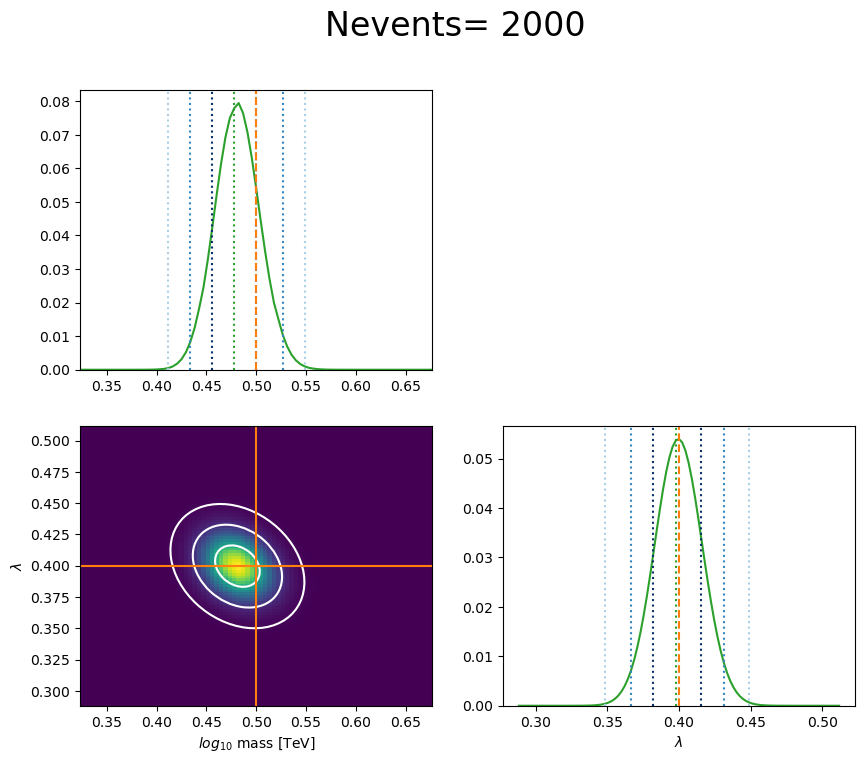